In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('../Data/csv_result-Descriptors_Training.csv', index_col='id')

In [3]:
df_valid = pd.read_csv('../Data/csv_result-Descriptors_Calibration.csv', index_col='id')

In [4]:
df_train.head(1)

,IP_ES_25_N1,Z3_IB_4_N1,Z1_IB_10_N1,Z1_IB_5_N1,Z3_IB_8_N1,ECI_IB_4_N1,ECI_IB_5_N1,Gs(U)_IB_12_N1,Gs(U)_IB_68_N1,Gs(U)_IB_58_N1,...,Z3_NO_UCR_S,Z3_NO_UCR_N1,ECI_NO_UCR_CV,Pa_NO_BSR_SI71,ISA_NO_NPR_S,Z3_NO_NPR_V,IP_NO_PLR_S,Pb_NO_PCR_V,ECI_NO_PCR_CV,class
id,,,,,,,,,,,,,,,,,,,,,
1,5.59,14.91,13.69,6.45,12.11,28.79,32.4,0.06,0.09,0.04,...,0.69,23.12,0.64,0.76,-0.79,0.68,0.54,0.02,0.59,P


In [5]:
predictors = df_train.drop(columns='class').columns

input_df = df_train[predictors]

#### Using Isolation forests to predict outliers

In [6]:
from sklearn.ensemble import IsolationForest

def detectOutliers(df, full_df, col_name='outliers'):
    
    clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), 
                      max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

    pred = clf.fit_predict(df)

    dummy_df = pd.concat(
        [
            full_df.reset_index(drop=True),
            pd.Series(pred, name=col_name)
        ], 
        axis=1)
    
    return dummy_df

In [7]:
dfw_outliers = detectOutliers(input_df, df_train)

In [8]:
#outlier_index = dfw_outliers[dfw_outliers['outliers'] == -1].index

In [9]:
dfw_outliers.head()

,IP_ES_25_N1,Z3_IB_4_N1,Z1_IB_10_N1,Z1_IB_5_N1,Z3_IB_8_N1,ECI_IB_4_N1,ECI_IB_5_N1,Gs(U)_IB_12_N1,Gs(U)_IB_68_N1,Gs(U)_IB_58_N1,...,Z3_NO_UCR_N1,ECI_NO_UCR_CV,Pa_NO_BSR_SI71,ISA_NO_NPR_S,Z3_NO_NPR_V,IP_NO_PLR_S,Pb_NO_PCR_V,ECI_NO_PCR_CV,class,outliers
0,5.59,14.91,13.69,6.45,12.11,28.79,32.40,0.06,0.09,0.04,...,23.12,0.64,0.76,-0.79,0.68,0.54,0.02,0.59,P,1
1,4.81,16.87,6.58,11.59,17.25,40.40,56.59,0.04,0.06,0.05,...,2.34,0.52,0.49,-1.27,1.39,-0.11,0.02,0.62,P,1
2,5.36,13.81,8.25,8.77,14.82,32.42,61.74,0.03,0.06,0.07,...,-2.24,0.37,0.47,-0.74,2.03,0.58,0.01,0.56,P,1
3,6.10,73.66,6.41,11.14,37.36,38.26,55.93,0.04,0.19,0.06,...,2.44,0.40,0.44,-0.28,0.43,0.77,0.02,0.65,P,1
4,-2.00,16.41,8.51,7.07,30.95,50.22,39.52,0.05,0.05,0.04,...,7.72,0.42,0.50,-1.12,0.91,0.71,0.01,0.65,P,1


outliers  class
 1        N        16661
-1        N         2200
 1        P          928
-1        P          199
dtype: int64

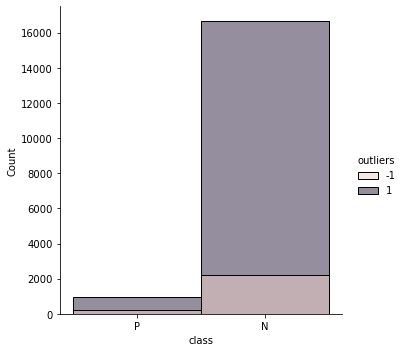

In [10]:
sns.displot(x='class',hue='outliers',data=dfw_outliers)
dfw_outliers[['outliers','class']].value_counts()

#### Using Gradient Boosting Classifier With Outliers

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

In [12]:
model = GradientBoostingClassifier()

model.fit(input_df, df_train['class'])

pred = model.predict(df_valid[predictors])

Precision: [0.94392149 0.33333333]
Recall: [0.99957582 0.00355872]


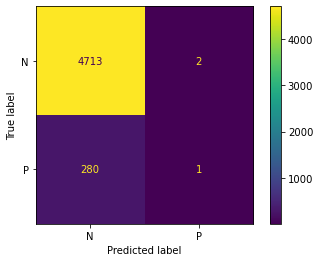

In [13]:
y_val = df_valid['class'].values
cm = confusion_matrix(df_valid['class'], pred)

print(f'Precision: {precision_score(y_val, pred,average=None)}')
print(f'Recall: {recall_score(y_val, pred,average=None)}')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['N','P'])
disp = disp.plot(include_values=True)

plt.show()

In [14]:
df_valid['class'].value_counts()

N    4715
P     281
Name: class, dtype: int64

#### Using Gradient Boosting Classifier without Outliers

In [15]:
df_no_outliers = dfw_outliers[dfw_outliers['outliers'] == 1]

ip_dfwo_out = df_no_outliers[predictors]

model_2 = GradientBoostingClassifier()

model_2.fit(ip_dfwo_out, df_no_outliers['class'])

GradientBoostingClassifier()

Pre-process Data

In [16]:
df_valid = detectOutliers(df_valid[predictors], df_valid)

In [17]:
df_valid_wo_outliers = df_valid[df_valid['outliers'] == 1]

In [18]:
df_valid_wo_outliers.head(1)

,IP_ES_25_N1,Z3_IB_4_N1,Z1_IB_10_N1,Z1_IB_5_N1,Z3_IB_8_N1,ECI_IB_4_N1,ECI_IB_5_N1,Gs(U)_IB_12_N1,Gs(U)_IB_68_N1,Gs(U)_IB_58_N1,...,Z3_NO_UCR_N1,ECI_NO_UCR_CV,Pa_NO_BSR_SI71,ISA_NO_NPR_S,Z3_NO_NPR_V,IP_NO_PLR_S,Pb_NO_PCR_V,ECI_NO_PCR_CV,class,outliers
0,15.35,13.06,9.08,7.15,18.86,34.99,38.64,0.03,0.05,0.04,...,-3.41,0.33,0.6,-1.59,0.7,0.33,0.02,0.62,P,1


Predictions - Model 

In [19]:
pred = model_2.predict(df_valid_wo_outliers[predictors])

Precision: [0.94919116 0.        ]
Recall: [0.99832255 0.        ]


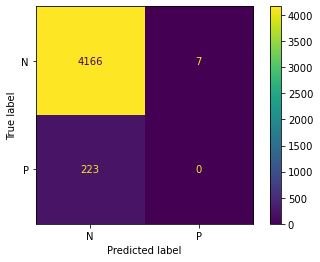

In [20]:
y_val = df_valid_wo_outliers['class'].values

cm = confusion_matrix(y_val, pred)

print(f'Precision: {precision_score(y_val, pred,average=None)}')

print(f'Recall: {recall_score(y_val, pred,average=None)}')


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['N','P'])
disp = disp.plot(include_values=True)

plt.show()

In [21]:
df_valid_wo_outliers['class'].value_counts()

N    4173
P     223
Name: class, dtype: int64

#### Create a pipeline for - Normalizing Data, Prediction Model

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [23]:
pipe = make_pipeline(StandardScaler(), GradientBoostingClassifier())

pipe.fit(input_df, df_train['class'])

prep_pred = pipe.predict(df_valid[predictors])

Precision: [0.94405454 0.22222222]
Recall: [0.99851538 0.00711744]


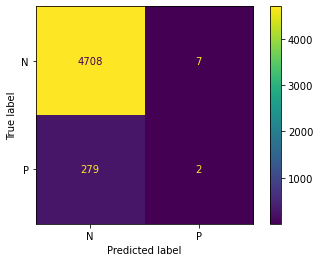

In [24]:
y_val = df_valid['class'].values

cm = confusion_matrix(y_val, prep_pred)

print(f'Precision: {precision_score(y_val, prep_pred,average=None)}')

print(f'Recall: {recall_score(y_val, prep_pred,average=None)}')


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['N','P'])
disp = disp.plot(include_values=True)

plt.show()

#### Create a pipeline for without outliers - Normalizing Data, Prediction Model

In [25]:
pipe_wo = make_pipeline(StandardScaler(), GradientBoostingClassifier())

pipe_wo.fit(ip_dfwo_out, df_no_outliers['class'])

prepwo_pred = pipe_wo.predict(df_valid_wo_outliers[predictors])

Precision: [0.9492143 0.       ]
Recall: [0.99880182 0.        ]


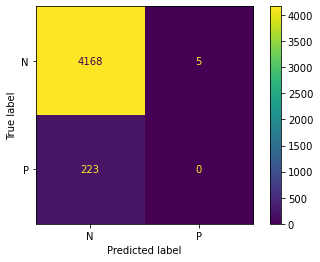

In [26]:
y_val = df_valid_wo_outliers['class'].values

cm = confusion_matrix(y_val, prepwo_pred)

print(f'Precision: {precision_score(y_val, prepwo_pred,average=None)}')

print(f'Recall: {recall_score(y_val, prepwo_pred,average=None)}')


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['N','P'])
disp = disp.plot(include_values=True)

plt.show()

Without Outliers we are losing **TP**

---
#### Using SMOTE for oversampling and random undersampling mix

In [27]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [28]:
std = StandardScaler()
smote_model = GradientBoostingClassifier()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('std',std), ('over', over), ('under', under), ('model', smote_model)]
pipeline = Pipeline(steps=steps)

In [29]:
pipeline.fit(input_df, df_train['class'])

Pipeline(steps=[('std', StandardScaler()),
                ('over', SMOTE(sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('model', GradientBoostingClassifier())])

In [30]:
smote_pred = pipeline.predict(df_valid[predictors])

Precision: [0.94743509 0.12355212]
Recall: [0.95185578 0.113879  ]


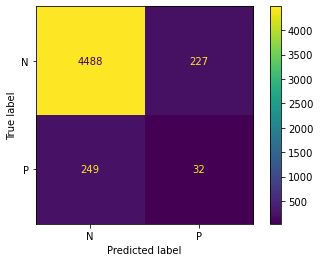

In [31]:
y_val = df_valid['class'].values

cm = confusion_matrix(y_val, smote_pred)

print(f'Precision: {precision_score(y_val, smote_pred,average=None)}')

print(f'Recall: {recall_score(y_val, smote_pred,average=None)}')


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['N','P'])
disp = disp.plot(include_values=True)

plt.show()

*Same as above without outliers*

Precision: [0.95104895 0.08032129]
Recall: [0.94512341 0.0896861 ]


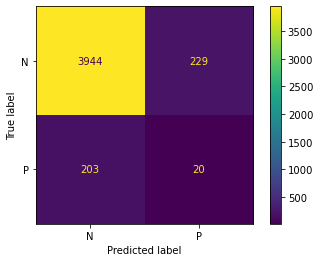

In [32]:
std_wo = StandardScaler()
smote_model_wo = GradientBoostingClassifier()
over_wo = SMOTE(sampling_strategy=0.1)
under_wo = RandomUnderSampler(sampling_strategy=0.5)
steps_wo = [('std',std_wo), ('over', over_wo), ('under', under_wo), ('model', smote_model_wo)]
pipeline = Pipeline(steps=steps_wo)

pipeline.fit(ip_dfwo_out, df_no_outliers['class'])

smote_pred_wo = pipeline.predict(df_valid_wo_outliers[predictors])

y_val = df_valid_wo_outliers['class'].values

cm = confusion_matrix(y_val, smote_pred_wo)

print(f'Precision: {precision_score(y_val, smote_pred_wo,average=None)}')

print(f'Recall: {recall_score(y_val, smote_pred_wo,average=None)}')


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['N','P'])
disp = disp.plot(include_values=True)

plt.show()